# Heat Maps

[Watch a walk-through of this lesson on YouTube](https://youtu.be/0BCmWZSfyWA)

---
## Learning Objectives
- Visualize spike train data along two dimensions using heat maps
- Create a 2D NumPy array of histograms to generate this plot
- Format a heat map, including adding a colourbar
- Understand the process of interpolation 
- Understand advantages and disadvantages of different ways of interpolating
- Understand how colour choice can influence the interpretation of heat maps
- Make well-reasoned choices about colour map selection

---

## Introduction
Heat maps are another way of plotting spike train data. An example is below:

![](images/heat_map.png)

Like a PSTH, the heat map has time on the *x* axis, and plots the probability of spikes at each time point. But we're able to show all intensity levels in a single plot, by putting intensity on the *y* axis and using colur, rather than bar height, to represent the number of spikes. Heat maps are a more condensed, information-rich, and efficient version of the PSTHs: rather than needing 10 plots to show the histograms for all 10 levels of intensity, we do so in a single plot. Heat maps allow us to plot *three dimensions* rather than only two; we have the *x* and *y* axes, and then we can plot a third variable (dimension) using colour (or intensity of colour). Think of it as if the above plot rotated in a plane, so that if before, you were looking at the plot from the side, now you're looking at it from above. More intense colours indicate a higher spike probability at that time point. 

We can use Matplotlib's [`ax.imshow()`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html) method (or `plt.imshow()` function) to generate a heat map. This function allows us to plot any 2-dimensional data set (like a 2D array) as an image, and apply colour to the values in the array. To demonstrate, first we'll load the necessary packages:

~~~python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
~~~

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load the data


~~~python
spikes = pd.read_csv('data/ten_intensities.csv')
~~~

In [3]:
spikes = pd.read_csv('data/ten_intensities.csv')
spikes

,Intensity,Trial,SpikeTime
0,0,1,14
1,0,1,18
2,0,3,14
3,0,3,20
4,0,4,14
...,...,...,...
226,9,9,9
227,9,9,12
228,9,9,13
229,9,9,16


## Define experimental parameters


~~~python
stim_on = 4   # time stimulus turned on
stim_off = 14 # time stimulus turned off
num_trials = 10 # number of trials per intensity level
num_tp = 21     # Number of time points in each trial (0-20 ms, inclusive)
num_intensities = 10 # number of stimulus intensities
~~~

In [4]:
stim_on = 4   # time stimulus turned on
stim_off = 14 # time stimulus turned off
num_trials = 10 # number of trials per intensity level
num_tp = 21     # Number of time points in each trial (0-20 ms, inclusive)
num_intensities = 10 # number of stimulus intensities

## Format data as histograms

Since heat maps are histograms, and `ax.imshow()` is designed to plot 2D arrays, we'll need to first convert the data to histograms for each intensity level, and then combine these into a 2D array.

Critically, here we are *creating* histograms for each intensity level in a loop, but not plotting them. That is, we will use the `np.histogram()` function to compute the histogram at each intensity level, and store it in a NumPy array. `np.histogram()` outputs two results: the histogram (a 1D array with a count of the number of spikes in each bin), and the *edges* of the bins (the values used to map the counts in each bin to positions on the *x* axis of the plot). Let's run this function just for one intensity level (9) so that we can see what the histogram looks like as a NumPy array:

~~~python
int_lev = 9

hist, bins = np.histogram(spikes[spikes['Intensity'] == int_lev]['SpikeTime'],
                         bins=num_tp,
                         range=(0, num_tp))

print("Histogram:", hist)
print("Histogram has", str(len(hist)), "values")
print()
print("Bin edges:", bins)
print("Bins has", str(len(bins)), "values")
~~~

In [5]:
intensity = 9

hist, bins = np.histogram(spikes[spikes['Intensity'] == 9]['SpikeTime'],
            bins = num_tp, range = (0, num_tp))

print('Histogram:', hist)
print(f'Histogram has {len(hist)} values')
print('Bin edges', bins)
print(f'Bin has {len(bins)} values')

Histogram: [3 0 0 0 0 1 0 2 7 4 2 4 4 1 0 0 2 3 3 0 0]
Histogram has 21 values
Bin edges [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
Bin has 22 values


The values in the `hist` array are the spike counts in each bin. Note that the `bins` array is one value longer than the number of values in the histogram, because these are the bin *edges* — the start and stop times of each bin. So, in the histogram above, the time starts at zero, and there are 3 spikes before 1 ms, then 0 spikes for the next 4 time points, and then 1 spike at 5 ms, etc.

Note that when we used the Matplotlib `.hist()` method in the previous lesson, this was just a shortcut to use NumPy to compute the histogram and generate the plot all in one step. We can actually see this if we use `plot.hist()` but omit the `plot.show()` function that we usually end a plot cell with, so that we don't hide that "extra" output that we normally don't want showing with our plot:

~~~python
plt.hist(spikes[spikes['Intensity'] == int_lev]['SpikeTime'],
         bins=num_tp,
         range=(0, num_tp))
~~~

(array([3., 0., 0., 0., 0., 1., 0., 2., 7., 4., 2., 4., 4., 1., 0., 0., 2.,
        3., 3., 0., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21.]),
 <BarContainer object of 21 artists>)

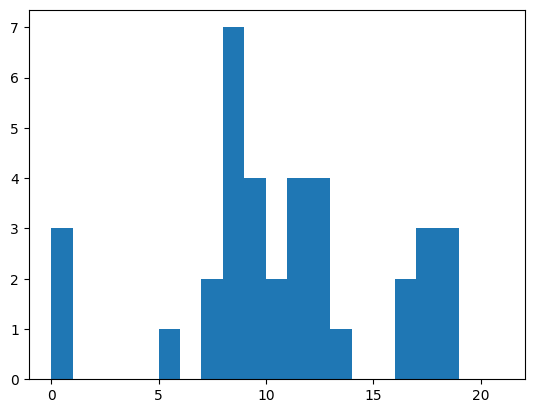

In [6]:
plt.hist(spikes[spikes['Intensity'] == intensity]['SpikeTime'],
         bins=num_tp,
         range=(0, num_tp))

## Create array of histograms

Since we don't want a bar plot of our histogram but a heat map, we just save the histograms into a 2D array and then plot them as a heat map. The 2D array we'll create is shaped exactly like the one above: with time as columns, and intensity levels as rows. Since we know in advance the dimensions of this array (10 rows and 21 columns), we can make a NumPy array of that shape (with a function called `np.zeros()`, which fills all cells with zero to start) and then fill each row as we go through the loop of intensities. Note that we're only saving the histogram part of the `np.histogram()` function, not the bins, since the bins are the same for every histogram. 

~~~python
# Create np array full of zeros to fill with histograms
hist = np.zeros([num_intensities, num_tp])

for i in range(num_intensities):
    hist[i, :], bins = np.histogram(spikes[spikes['Intensity'] == i]['SpikeTime'],
                             bins=num_tp,
                             range=(0, num_tp))
~~~

In [7]:
# Create np array full of zeros to fill with histograms
hist = np.zeros([num_intensities, num_tp])

for i in range(num_intensities):
    hist[i, :], bins = np.histogram(spikes[spikes['Intensity'] == i]['SpikeTime'],
                             bins=num_tp,
                             range=(0, num_tp))

Now if we look at the NumPy array we see that, indeed, we have 9 rows, each comprising the histogram for one intensity level: 

~~~python
print(hist)
~~~

In [8]:
print(hist)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 3. 0. 0. 0. 2. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 0. 1. 1. 1. 2. 2. 0. 2.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 2. 0. 2. 0. 1. 0. 1. 0. 1. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 3. 1. 1. 0. 5. 2. 3. 0. 4. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 2. 0. 1. 2. 3. 4. 5. 3. 2. 4. 1. 2. 3.]
 [0. 0. 0. 1. 0. 0. 1. 2. 1. 3. 8. 5. 1. 3. 6. 0. 2. 5. 0. 4. 3.]
 [1. 1. 0. 0. 0. 0. 1. 0. 6. 8. 3. 6. 2. 5. 1. 0. 3. 5. 5. 1. 0.]
 [3. 0. 0. 0. 0. 1. 0. 2. 7. 4. 2. 4. 4. 1. 0. 0. 2. 3. 3. 0. 0.]]


## Draw heat map
Now that we have our array of histograms, we simply pass it as the single argument to `plt.imshow()`:

~~~python
plt.imshow(hist)
plt.show()
~~~

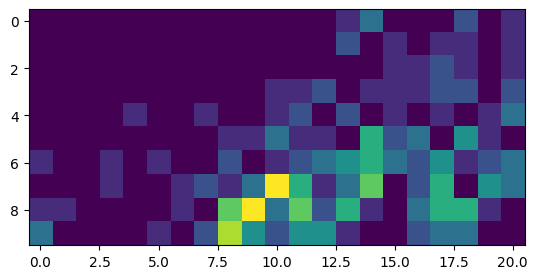

In [9]:
plt.imshow(hist)
plt.show()

<div class="alert alert-block alert-info">

You may notice we're using procedural plotting with `plt` functions rather than than using the object-oriented approach you've been encouraged to use. This is because, when we just want to show one plot and not worry about details, this approach uses only one line of code.
    </div>

## Format the heat map

The above plot is far less pretty than the one at the top of this section! We need to pass additional arguments to `plt.imshow()`, and then add some more generic Matplotlib tweaks in order to get it to look the way we want. While we're at it, we'll switch to object-oriented plotting.

Below, the arguments we add are:
- the `origin` argument puts 0 on the *y* axis at the bottom, rather than the top, which makes sense in this case since the *y* axis typically goes from lowest to highest values bottom-to-top. 
- the `cmap` argument sets the colour map to 'hot'. (For a list of Matplotlib colour maps, see [this page](https://matplotlib.org/tutorials/colors/colormaps.html))
- the `interpolation` argument changes that mathematical formula is used to determine the colour values at each point in the plot. The default *antialiased* method produces a blocky-looking output above because it's computing the colour of each pixel in the plot based on the values in the histogram, which are computed at 1 ms intervals. Using *bilinear* interpolation estimates the values on a finer time scale, making the plot appear more smooth and continuous.   

We'll also set the range and spacing of the tick marks on the *x* and *y* axes similar to in the previous lesson 

~~~python
fig, ax = plt.subplots(figsize=[10,10])

ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Set tick mark range and spacing
ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_yticks(range(num_intensities))

plt.show()
~~~

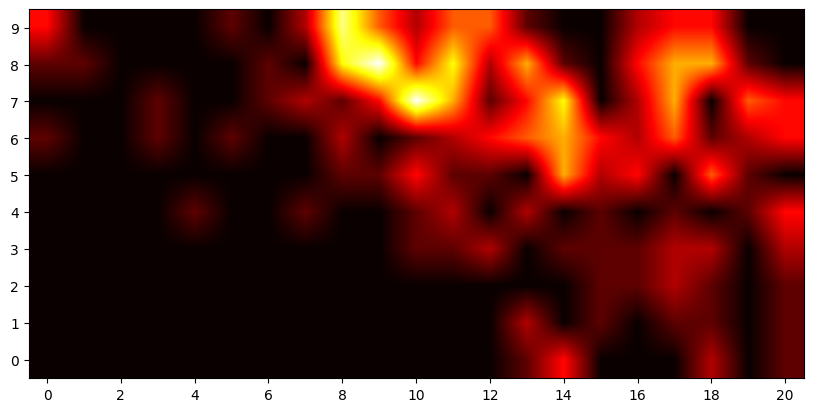

In [10]:
fig, ax = plt.subplots(figsize=[10,10])

ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Set tick mark range and spacing
ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_yticks(range(num_intensities))

plt.show()

## Label the heat map

Now we can add labels that help with interpretation, such as axis labels and a title. 

We'll also use `ax.avline()` to draw lines on the plot for the stimulus on and off times, because this is critical information for interpreting the figure. This method plots a vertical line spanning the whole plot, at the point on the *x* axis you specify. Note that unlike the previous lessons, we don't want to use shading to indicate the stimulus on period, because we're using colour in this plot to represent spike rate. 

~~~python
fig, ax = plt.subplots(figsize=[10,10])

ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Show stimulus on and off times
ax.axvline(stim_on, color='white', linestyle='--')
ax.axvline(stim_off, color='white', linestyle='--')

ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_xlabel('Time (ms)')

ax.set_yticks(range(num_intensities))
ax.set_ylabel('Stimulus Intensity')

ax.set_title('Probability of spiking across intensity levels')

plt.show()
~~~

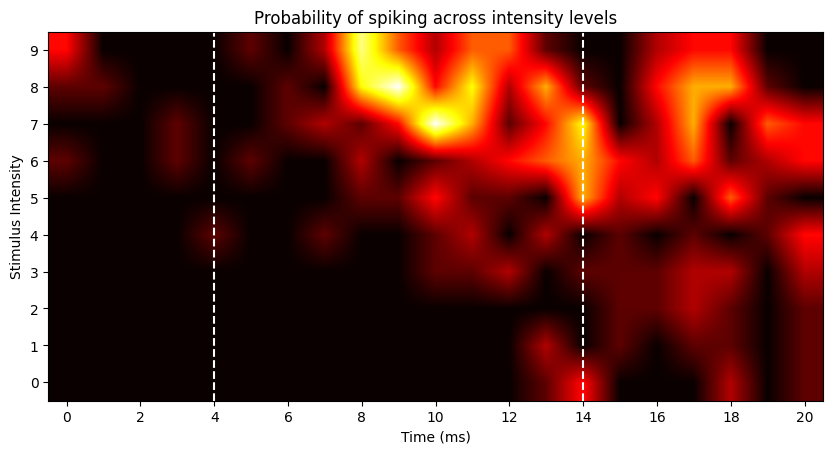

In [11]:
fig, ax = plt.subplots(figsize=[10,10])

ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Show stimulus on and off times
ax.axvline(stim_on, color='white', linestyle='--')
ax.axvline(stim_off, color='white', linestyle='--')

ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_xlabel('Time (ms)')

ax.set_yticks(range(num_intensities))
ax.set_ylabel('Stimulus Intensity')

ax.set_title('Probability of spiking across intensity levels')

plt.show()

## Add a colourbar

The heat map is looking great, but viewers will still not know what the colours mean! What is "red" versus "yellow" in terms of number of spikes? 

To convey this information, we need a colourbar, which is effectively a legend explaining what values different colours map to. 

In order to plot a colourbar, we need to do something new when we generate our plot with `.imshow()`: we need to assign the result of this command to a variable name (`im`). This variable then acts as a **pointer** to the plot, meaning we can use it to refer to the plot later. This is how the method we use to generate the colourbar will get the data from the image. We haven't assigned the output of Matplotlib commands to variables before, because we've had no need to, but now we do. 

~~~python
fig, ax = plt.subplots(figsize=[10,10])

# make im a pointer to the image
im = ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Show stimulus on and off times
ax.axvline(stim_on, color='white', linestyle='--')
ax.axvline(stim_off, color='white', linestyle='--')

ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_xlabel('Time (ms)')

ax.set_yticks(range(num_intensities))
ax.set_ylabel('Stimulus Intensity')

ax.set_title('Probability of spiking across intensity levels')

# Create a colourbar using the im pointer. 
fig.colorbar(im)

plt.show()
~~~

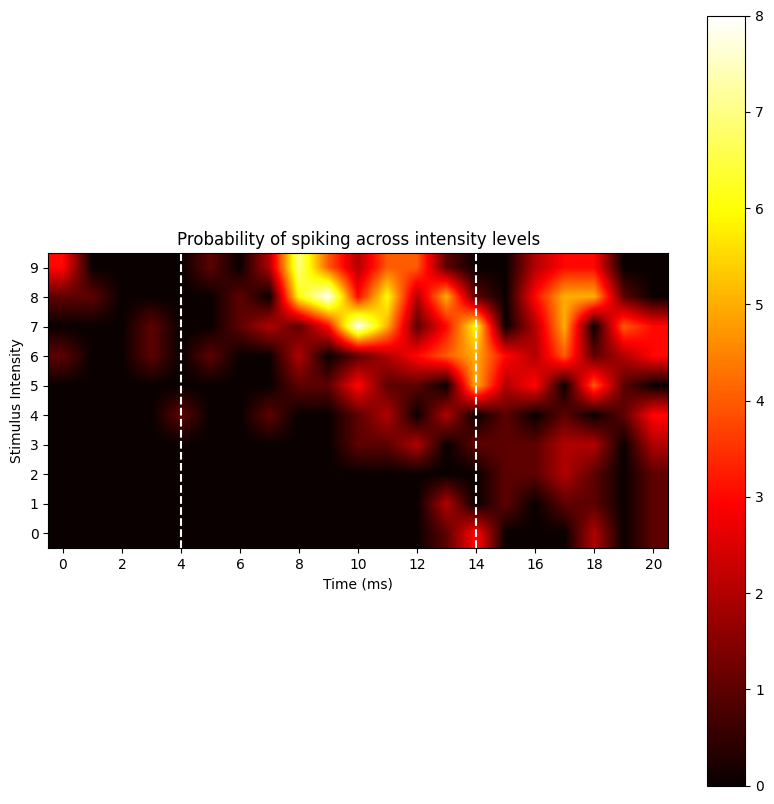

In [12]:
fig, ax = plt.subplots(figsize=[10,10])

# make im a pointer to the image
im = ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Show stimulus on and off times
ax.axvline(stim_on, color='white', linestyle='--')
ax.axvline(stim_off, color='white', linestyle='--')

ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_xlabel('Time (ms)')

ax.set_yticks(range(num_intensities))
ax.set_ylabel('Stimulus Intensity')

ax.set_title('Probability of spiking across intensity levels')

# Create a colourbar using the im pointer. 
fig.colorbar(im)

plt.show()

### Clean up the colourbar

So now we have a colourbar, but it's huge! Fortunately there's a kwarg for that: `shrink`. We'll also make the figure larger so that things are more visible.

Also, we're going to add a text label to explain what the numbers on the clourbar are. To do this, we need to create a pointer to the colourbar (which technically is a second subplot in the figure) and then use that pointer to set the label. 

If this seems convoluted, it is — at least, it reflects the power and complexity of Matplotlib. We can't simply add a "colourbar" kwarg to `.imshow()` because the colourbar actually needs to be its own subplot, and it relies on data created when the plot is draw. Procedures like this are typically something you figure out by finding examples like this one, or other tutorials on the web.

~~~python
fig, ax = plt.subplots(figsize=[15, 15])

# make im a pointer to the image
im = ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Show stimulus on and off times
ax.axvline(stim_on, color='white', linestyle='--')
ax.axvline(stim_off, color='white', linestyle='--')

ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_xlabel('Time (ms)')

ax.set_yticks(range(num_intensities))
ax.set_ylabel('Stimulus Intensity')

ax.set_title('Probability of spiking across intensity levels')

# Create a colourbar using the im pointer. 
cb = fig.colorbar(im, shrink=0.33)
cb.ax.set_ylabel('Spike Probability')

plt.show()
~~~

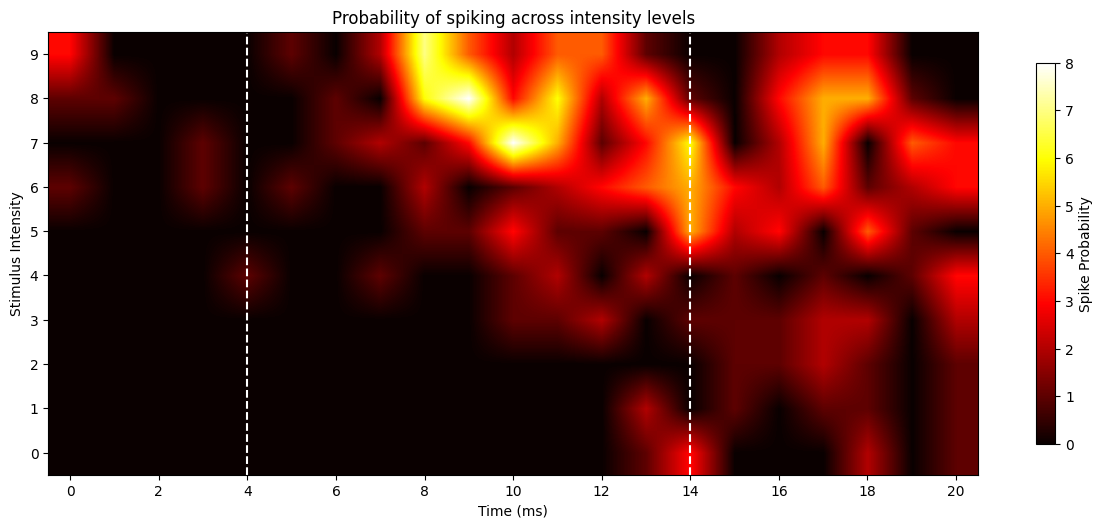

In [13]:
fig, ax = plt.subplots(figsize=[15, 15])

# make im a pointer to the image
im = ax.imshow(hist,
          origin='lower',
          cmap='hot', 
          interpolation='bilinear'
          )

# Show stimulus on and off times
ax.axvline(stim_on, color='white', linestyle='--')
ax.axvline(stim_off, color='white', linestyle='--')

ax.set_xticks(range(0, num_tp + 1, 2))
ax.set_xlabel('Time (ms)')

ax.set_yticks(range(num_intensities))
ax.set_ylabel('Stimulus Intensity')

ax.set_title('Probability of spiking across intensity levels')

# Create a colourbar using the im pointer. 
cb = fig.colorbar(im, shrink=0.33)
cb.ax.set_ylabel('Spike Probability')

plt.show()

## Interpretation

The heat map above makes a few interesting properties of the data immediately evident, more clearly and concisely than ten PSTHs or raster plots. For example, it's clear that spiking increases with stimulus intensity, particularly after 7 ms. It's also apparent that there is a threshold level of intensity below which very little spiking occurs, and above which there are stronger responses to the stimuli. 

As well, the heat map shows — perhaps even more convincingly than the individual PSTHs in the previous lesson — that as intensity increases, the latency to first spike becomes shorter (i.e., the neuron spikes sooner after a more intense stimulus).

## Considerations in generating heat maps

### Filling in the blanks: Interpolation

For better or for worse, a consequence of the bilinear interpolation is that it takes data that were measured at discrete levels of stimulus intensity, and interpolates between those levels to provide a smoothed representation of the data. In other words, it's making inferences about what the values would be in between the tested levels of stimulus intensity. In contrast, in the original *nearest neighbour* heat map we created, each square in the plot represented the number of spikes in one bin in a PSTH. So the nearest neighbour approach is a more literal representation of the data, but the bilinear interpolation makes inferences about the data points we didn't measure (and also just looks nicer to most people).

This is not to imply that interpolation is invalid; indeed it's a valuable tool and interpolation methods are mathematical formulae that are reproducible and well-understood. In this heat map, the dimensions on both the *x* and *y* axes (time and light intensity) are [**continuous**](../visualization/plotting_types) values that we have [**discretized**](../visualization/plotting_types) into a set of levels for the purposes of measuring spikes in this experiment. So interpolating between the measured values makes sense, because then we are representing these variables in a more continuous fashion than just the levels that we have data for. 

Nonetheless, it's important to be aware of interpolation and consider what effects it might have in some situations. On the positive side, interpolation can reduce noise in the data by smoothing it. On the other hand, if there are big gaps in your data it may not be appropriate to interpolate, because interpolation makes certain assumptions about the shape (distribution) of your data - and the differences between interpolation methods amount to the differences in assumptions that are made.

Below are examples showing different interpolation methods. Bicubic is the smoothest-looking, where nearest-neighbor looks "blocky" because it's plotting the actual values with no interpolation, more consistent with the actual data. The Hanning method produces results that appear somewhat in between the others. 

~~~python
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

# Nearest neighbour (default)
axs[0, 0].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                )

axs[0, 0].set_title('Nearest Neighbour')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])

# Blinear
axs[0, 1].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                 interpolation='bilinear'
                )

axs[0, 1].set_title('Bilinear')
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])

# Hanning
axs[1, 0].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                 interpolation='hanning'
                )

axs[1, 0].set_title('Hanning')
axs[1, 0].set_yticks([])
axs[1, 0].set_xticks([])

# Bicubic
axs[1, 1].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                 interpolation='bicubic'
                 )

axs[1, 1].set_title('Bicubic')
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])

plt.show()
~~~

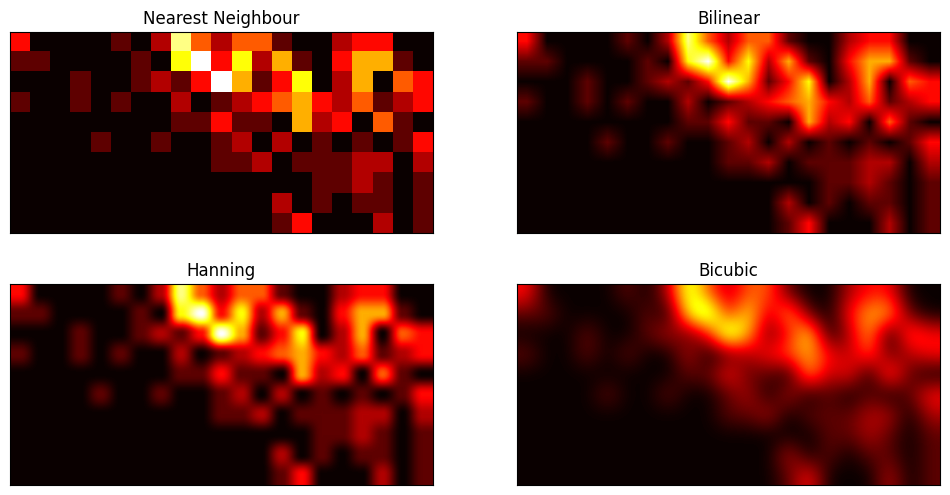

In [14]:
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

# Nearest neighbour (default)
axs[0, 0].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                )
axs[0, 0].set_title('Nearest Neighbour')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])
# Blinear
axs[0, 1].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                 interpolation='bilinear'
                )
axs[0, 1].set_title('Bilinear')
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])
# Hanning
axs[1, 0].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                 interpolation='hanning'
                )
axs[1, 0].set_title('Hanning')
axs[1, 0].set_yticks([])
axs[1, 0].set_xticks([])
# Bicubic
axs[1, 1].imshow(hist,
                 origin='lower',
                 cmap='hot', 
                 interpolation='bicubic'
                 )
axs[1, 1].set_title('Bicubic')
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])
plt.show()

### Colour Map Choices

One final comment about the heat maps above: your choice of colour map (`cmap`) matters. One way to choose a colour map is based on one's individual intuitions about aesthetics. For example, I personally think the one used above (`hot`) is quite attractive. However, it's important to consider the neuroscience of how humans interpret colour. Even though the colour spectrum is continuous (wavelengths of electromagnetic radiation ranging from approximately 400–700 nm), we see it as distinct colours (classically, red, orange, yellow, green, blue, indigo, and violet). Although we can discriminate different hues within each of those colours, we nonetheless see colours categorically. In other words, two equally-different values at different parts of the colour range may not be perceived as the same magnitude of difference. For example in the bottom left (`cmap='jet'`) the green areas seem to 'pop' relative to the blue, and there is are patches of orange that really stand out. 

~~~python
fig, ax = plt.subplots()

ax.imshow(hist,
                origin='lower',
                cmap='jet', 
                interpolation='bicubic'
               )

ax.set_yticks([])
ax.set_xticks([])
plt.show()
~~~

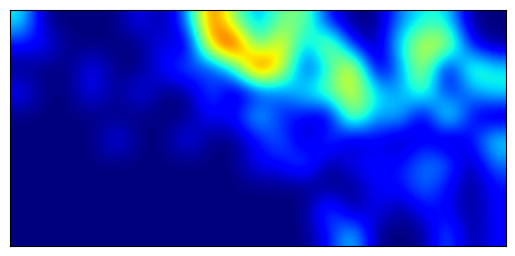

In [15]:
fig, ax = plt.subplots()

ax.imshow(hist,
                origin='lower',
                cmap='jet', 
                interpolation='bicubic'
               )

ax.set_yticks([])
ax.set_xticks([])
plt.show()

On the other hand, if we use a monochromatic (single-colour) map, the differences in numerical values are represented in a more continuous fashion, as the intensity (brightness) of the pixel, resulting in smoother, more continuous-looking gradients:

~~~python
fig, ax = plt.subplots()

ax.imshow(hist,
                origin='lower',
                cmap='gray', 
                interpolation='bicubic'
               )

ax.set_yticks([])
ax.set_xticks([])
plt.show()
~~~

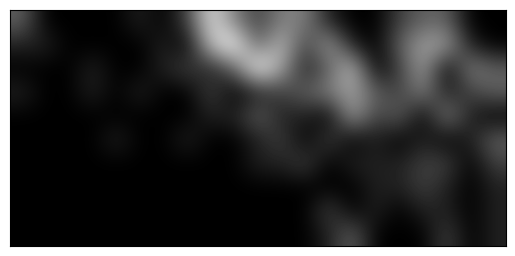

In [18]:
fig, ax = plt.subplots()

ax.imshow(hist,
                origin='lower',
                cmap='gray', 
                interpolation='bicubic'
               )

ax.set_yticks([])
ax.set_xticks([])
plt.show()

### Luminance

Another issue with some colour maps are that they are not always **isoluminent**, meaning that the luminance (brightness) of some colours may be greater than others, again making some differences appear larger than others, even when those differences are of the same numerical size.


### Colourblindness

A final issue, discussed earlier in this book, is that a non-negligible proportion of the population has some form of colourblindness.  Recall that the incidence of colourblindness is such that if 20 people view a graph you make, the odds are at least one of them will not see the colours in your plot as you do (unless of course you are colourblind yourself). 

### Perceptual uniformity

In other words, choosing the wrong colour map can mislead viewers in interpreting the data, and may also result in your plots being uninterpretable by some viewers. You should pick a colour map that is **perceptually uniform** (e.g., nearby values have similar-appearing colours across the range), and robust to colourblindness. An excellent choice is one of the [Viridis](https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html) family of colourmaps, which were explicitly designed to have these properties, and also be aesthetically appealing. The four colourmaps in the Viridis family is used below.

<div class="alert alert-block alert-info">
    There is a great app that simulates different forms of colourblindness on your computer, called [Color Oracle](https://colororacle.org) — it's worth checking out! 
</div>


~~~python
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

axs[0, 0].imshow(hist,
                origin='lower',
                cmap='viridis', 
                interpolation='bicubic'
              )

axs[0, 0].set_title('Viridis')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])

axs[0, 1].imshow(hist,
                origin='lower',
                cmap='plasma', 
                interpolation='bicubic'
               )

axs[0, 1].set_title('Plasma')
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])

axs[1, 0].imshow(hist,
                origin='lower',
                cmap='magma', 
                interpolation='bicubic'
               )

axs[1, 0].set_title('Magma')
axs[1, 0].set_yticks([])
axs[1, 0].set_xticks([])

axs[1, 1].imshow(hist,
                origin='lower',
                cmap='inferno', 
                interpolation='bicubic'
               )

axs[1, 1].set_title('Inferno')
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])

plt.show()
~~~

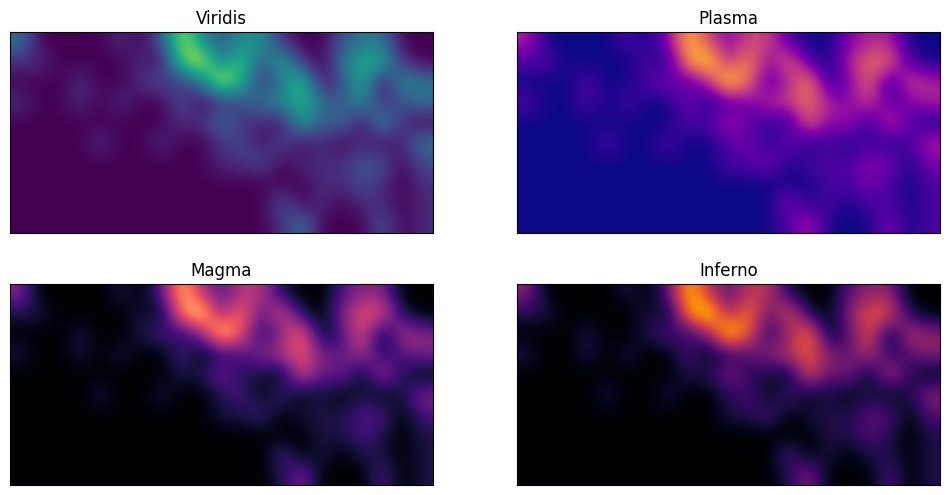

In [19]:
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

axs[0, 0].imshow(hist,
                origin='lower',
                cmap='viridis', 
                interpolation='bicubic'
              )

axs[0, 0].set_title('Viridis')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])

axs[0, 1].imshow(hist,
                origin='lower',
                cmap='plasma', 
                interpolation='bicubic'
               )

axs[0, 1].set_title('Plasma')
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])

axs[1, 0].imshow(hist,
                origin='lower',
                cmap='magma', 
                interpolation='bicubic'
               )

axs[1, 0].set_title('Magma')
axs[1, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 1].imshow(hist,
                origin='lower',
                cmap='inferno', 
                interpolation='bicubic'
               )

axs[1, 1].set_title('Inferno')
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])

plt.show()

### Violations of perceptual uniformity

Compare these plots to  ones above that use non-viridis colourmaps (including the ones above, and some more examples below) and ask yourself how your perception and interpretation of the plots changes between them. 

~~~python
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

axs[0, 0].imshow(hist,
                origin='lower',
                cmap='RdBu', 
                interpolation='bicubic'
              )

axs[0, 0].set_title('RdBu')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])

axs[0, 1].imshow(hist,
                origin='lower',
                cmap='hsv', 
                interpolation='bicubic'
               )

axs[0, 1].set_title('HSV')
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])

axs[1, 0].imshow(hist,
                origin='lower',
                cmap='jet', 
                interpolation='bicubic'
               )

axs[1, 0].set_title('Jet')
axs[1, 0].set_yticks([])
axs[1, 0].set_xticks([])

axs[1, 1].imshow(hist,
                origin='lower',
                cmap='Accent', 
                interpolation='bicubic'
               )

axs[1, 1].set_title('Accent')
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])

plt.show()
~~~

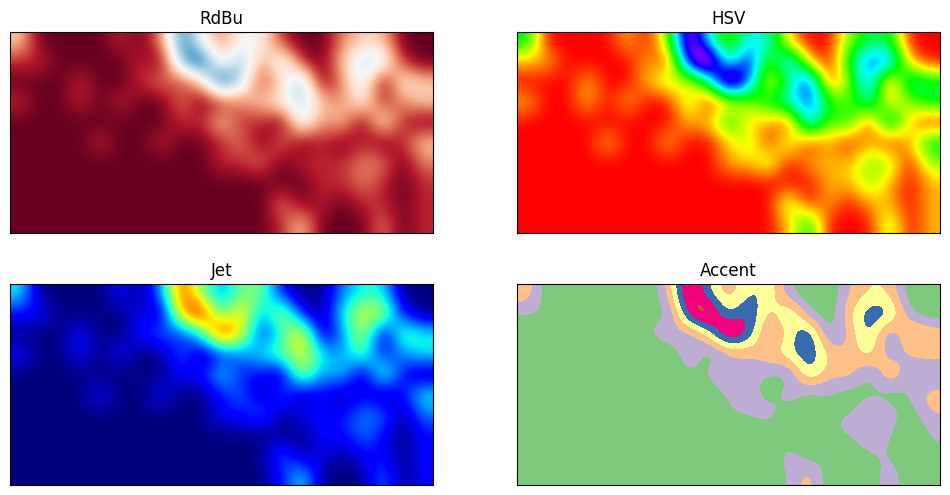

In [20]:
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

axs[0, 0].imshow(hist,
                origin='lower',
                cmap='RdBu', 
                interpolation='bicubic'
              )

axs[0, 0].set_title('RdBu')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])

axs[0, 1].imshow(hist,
                origin='lower',
                cmap='hsv', 
                interpolation='bicubic'
               )

axs[0, 1].set_title('HSV')
axs[0, 1].set_yticks([])
axs[0, 1].set_xticks([])

axs[1, 0].imshow(hist,
                origin='lower',
                cmap='jet', 
                interpolation='bicubic'
               )

axs[1, 0].set_title('Jet')
axs[1, 0].set_yticks([])
axs[1, 0].set_xticks([])

axs[1, 1].imshow(hist,
                origin='lower',
                cmap='Accent', 
                interpolation='bicubic'
               )

axs[1, 1].set_title('Accent')
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])

plt.show()

In all of these last four plots, the colour maps make continuous differences look highly *dis*continuous

---

## Summary

- Heat maps allow us to visualize the relationship between three continuous variables, using colour to represent one variable
- A heat map is effectively a 2D image, and can be represented by a 2D NumPy array
- We can save a pointer to a Matplotlib image (object) that we create, by assigning the result of generating the image to a variable name
- These pointers to plots can be used by some other Matplotlib commands, such as for creating colourbars
- Interpolation is the process of determining how to fill in the missing values between data points, for plotting smooth, continuous plots such as heat maps
- Different interpolation methods trade off between being more literal representations of the measured data, to smoother-looking representations based on fitting mathematical functions to the data
- The choice of colour scales in heat maps and other images is even more important than for other types of plots, because non-linear changes in hue (colour) or intensity (luminance) can trick the human eye/brain into seeing continuous data as more discontinuous. Such distortions can interfere with correct interpretation of the data.
- It is best to use an isoluminant, perceptually uniform colour scale when plotting continuous data such as heat maps and other images.
